In [1]:

import sys
sys.path
sys.path.append('/Users/agos/Dropbox/ColumbiaProjects/Dans_Data_Package/analysis_dan')
sys.path.append('/Users/agos/Dropbox/ColumbiaProjects/Dans_Data_Package/OASIS-master')

import warnings
warnings.filterwarnings('ignore')

import calnet.calnet as cc
import calnet.dynamics as dyn
import numpy as np
from importlib import reload
import pdb
import matplotlib.pyplot as plt
import glob
import calnet.utils as utils
import pyute as ut
import size_contrast_analysis as sca
import size_contrast_figures as scf
import size_contrast_opto_figures as scof
import opto_utils
import os
import scipy.stats as sst
reload(cc)
reload(utils)

<module 'calnet.utils' from '/Users/agos/Dropbox/ColumbiaProjects/Dans_Data_Package/analysis_dan/calnet/utils.py'>

In [116]:
os.getcwd()

figures_path='/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/figures_notebooks_agos'

In [3]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('Reds')


In [4]:
cache_base = os.path.expanduser('~/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/mossing_paper_code')
if not os.path.exists(cache_base):
    os.makedirs(cache_base)
cache_base = os.path.join(cache_base, "vip_sst_subnetwork_dynamics_")

In [5]:
# weights_files = glob.glob('../shared_data/calnet_data/weights/weights_201215b/*.npy')
weights_files = glob.glob('/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/calnet_data/weights/weights_210513c/*.npy')
weights_files.sort()


In [29]:
# npyfile = np.load('../shared_data/calnet_data/dynamics/pc_small_opto_tavg_201203g.npy',allow_pickle=True)[()]
# npyfile = np.load('../shared_data/calnet_data/dynamics/pc_opto_tavg_201203g.npy',allow_pickle=True)[()]
# npyfile = np.load('../shared_data/calnet_data/dynamics/sst_both_pixels_opto_tavg_201215b.npy',allow_pickle=True)[()]
# npyfile = np.load('../shared_data/calnet_data/dynamics/pc_opto_tavg_vip_silencing_201203g.npy',allow_pickle=True)[()]
npyfile_coupled = np.load('/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/calnet_data/dynamics/vip_both_pixels_opto_tavg_l4_coupled_0_25_210513c.npy',allow_pickle=True)[()]


In [7]:
nwt = len(weights_files)
losses = np.zeros((nwt,))
for iwt in range(nwt):
    wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
    losses[iwt] = cc.ModelOri(wtdict,nT=1).loss
    

In [8]:
# weights_files = glob.glob('../shared_data/calnet_data/weights/weights_201203g/*.npy')


import run_calnet_pc_opto_sims

all_mdls = run_calnet_pc_opto_sims.build_models(weights_files)

mdls,mdls_no_pcpc,mdls_no_pcpv,mdls_no_pcvip,mdls_no_pcsst,mdls_no_vipbias,mdls_no_sstvip = all_mdls

low_loss = (losses<np.nanpercentile(losses,10)) #& (npyfile['YY_opto'][:,-1].max(1).max(1)<10)

mdls = [mdl for (mdl,ll) in zip(mdls,low_loss) if ll]
mdls_no_pcpv = [mdl for (mdl,ll) in zip(mdls_no_pcpv,low_loss) if ll]
mdls_no_pcpc = [mdl for (mdl,ll) in zip(mdls_no_pcpc,low_loss) if ll]
mdls_no_pcvip = [mdl for (mdl,ll) in zip(mdls_no_pcvip,low_loss) if ll]
mdls_no_pcsst = [mdl for (mdl,ll) in zip(mdls_no_pcsst,low_loss) if ll]
mdls_no_vipbias = [mdl for (mdl,ll) in zip(mdls_no_vipbias,low_loss) if ll]
mdls_no_sstvip = [mdl for (mdl,ll) in zip(mdls_no_sstvip,low_loss) if ll]

weights_files = [wf for (wf,ll) in zip(weights_files,low_loss) if ll]

# low_loss = (npyfile['YY_opto'][:,-1].max(1).max(1)<10)


# Load sims

In [9]:

#npyfile = np.load('/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/calnet_data/dynamics/vip_both_pixels_opto_tavg_l4_coupled_0_25_210513c.npy',allow_pickle=True)[()]
npyfile = np.load('/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/calnet_data/dynamics/vip_both_pixels_opto_tavg_l4_coupled_0_25_210513c.npy',allow_pickle=True)[()]


YY_opto = npyfile['YY_opto'][:,:,:,np.newaxis,:]
YY_opto_no_pcpc = npyfile['YY_opto_no_pcpc'][:,:,:,np.newaxis,:]
YY_opto_no_pcpv = npyfile['YY_opto_no_pcpv'][:,:,:,np.newaxis,:]
YY_opto_tavg_no_pcvip = npyfile['YY_opto_tavg_no_pcvip'][:,:,:,np.newaxis,:]
YY_opto_tavg_no_pcsst = npyfile['YY_opto_tavg_no_pcsst'][:,:,:,np.newaxis,:]
YY_opto_tavg_no_vipbias = npyfile['YY_opto_tavg_no_vipbias'][:,:,:,np.newaxis,:]
YY_opto_tavg_no_sstvip = npyfile['YY_opto_tavg_no_sstvip'][:,:,:,np.newaxis,:]


In [10]:
YY_opto.shape

(94, 41, 36, 1, 8)

# Params for plots

In [11]:
Niter = int(1e3)
# opto_levels = 1*np.linspace(-1.5,1.5,31)
opto_levels = 1*np.linspace(-1,1,YY_opto.shape[1])
dt = 1e-1
nopto = len(opto_levels)
ucontrast=np.array([0,6,12,25,50,100])

In [12]:
# weights_files = glob.glob('../shared_data/calnet_data/weights/weights_201215b/*.npy')
# weights_files.sort()

reload(cc)
nwt = len(weights_files)
mdls = [None for iwt in range(nwt)]
losses = np.zeros((nwt,))
for iwt in range(nwt):
#     wtfile = 'weights_'+good_fits[iwt]+'.npy'
#     wtdict = np.load(wtbase+wtfile,allow_pickle=True)[()]
    wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
    mdls[iwt] = cc.ModelOri(wtdict,nT=1)
    losses[iwt] = mdls[iwt].loss
    
mdls_no_pcpv = [None for iwt in range(nwt)]
for iwt in range(nwt):
    wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
    wtdict['Wmy'][[0,0,3,3],[0,3,0,3]] = 0
    mdls_no_pcpv[iwt] = cc.ModelOri(wtdict,nT=1)
    
mdls_no_pcpc = [None for iwt in range(nwt)]
for iwt in range(nwt):
    wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
    wtdict['Wmy'][0,0] = 0
    mdls_no_pcpc[iwt] = cc.ModelOri(wtdict,nT=1)

In [13]:
opto_levels.shape

(41,)

In [14]:
iwt = 0
nQ,nS,nT = mdls[iwt].nQ,mdls[iwt].nS,mdls[iwt].nT
bltiles = np.zeros((nwt,nQ*nS*nT))
amps = np.ones((nwt,nQ*nS*nT))
for iwt in range(nwt):
    wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
    if 'bl' in wtdict:
        bl = wtdict['bl']
        bltiles[iwt] = np.tile(bl,nS*nT)
    if 'amp' in wtdict:
        amp = wtdict['amp']
        amps[iwt] = amp

# Compute response

In [15]:
YY_opto_no_pcpv.shape

(94, 41, 36, 1, 8)

In [16]:
np.nanmean(YY_opto[iwt],2) .shape # models_nr, opto levels, size/contrast, time, cell type

(41, 36, 8)

In [17]:

nwt = len(mdls)
iwt = 0
itype = 0

nN = mdls[iwt].nN
ntypes = mdls[iwt].nQ*mdls[iwt].nS*mdls[iwt].nT
this_mdl,this_YY = mdls_no_pcpc.copy(),YY_opto_no_pcpc.copy()
# this_mdl,this_YY = mdls_no_pcpv.copy(),YY_opto_no_pcpv.copy()
# this_mdl,this_YY = mdls.copy(),YY_opto.copy()
network_resp = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
network_resp_no_pcpc = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
network_resp_no_pcpv = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
network_resp_no_pcvip = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
network_resp_no_pcsst = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
network_resp_no_vipbias = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
network_resp_no_sstvip = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
cell_intrinsic_resp = np.zeros((nwt,opto_levels.shape[0],nN,ntypes))
for iwt in range(nwt):
    network_resp[iwt] = np.nanmean(YY_opto[iwt],2) # time avg
    network_resp_no_pcpc[iwt] = np.nanmean(YY_opto_no_pcpc[iwt],2)
    network_resp_no_pcpv[iwt] = np.nanmean(YY_opto_no_pcpv[iwt],2)
    network_resp_no_pcvip[iwt] = np.nanmean(YY_opto_tavg_no_pcvip[iwt],2) # time avg
    network_resp_no_pcsst[iwt] = np.nanmean(YY_opto_tavg_no_pcsst[iwt],2)
    network_resp_no_vipbias[iwt] = np.nanmean(YY_opto_tavg_no_vipbias[iwt],2)
    network_resp_no_sstvip[iwt] = np.nanmean(YY_opto_tavg_no_sstvip[iwt],2)

    for ilevel in range(opto_levels.shape[0]):
        cell_intrinsic_resp[iwt,ilevel] = this_mdl[iwt].compute_f_(opto_levels[ilevel]+this_mdl[iwt].Eta,this_mdl[iwt].Xi,this_mdl[iwt].s02)


In [18]:
network_resps = [network_resp,
        network_resp_no_pcpc,
        network_resp_no_pcpv,
        network_resp_no_pcvip,
        network_resp_no_pcsst,
        network_resp_no_vipbias,
        network_resp_no_sstvip]

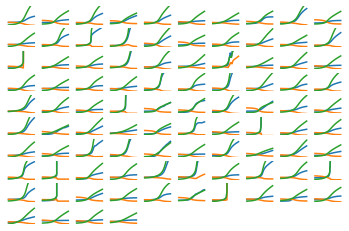

In [19]:
iwt = 2
istim = 0
plt.figure()
for iwt in range(network_resp.shape[0]):
    plt.subplot(10,10,iwt+1)
    for itype in range(3):
        plt.plot(opto_levels,network_resp[iwt,:,istim,itype]) #opto_levels,
    plt.ylim((0,2.5))
    plt.axis('off')
    

In [20]:
import sklearn.linear_model as sklm
# fit optimal linear combination
def get_linear_prediction(x, y):
    linreg = sklm.LinearRegression(fit_intercept=True)
    xflat = x.flatten()[:, None]
    yflat = y.flatten()[:, None]
    linreg.fit(xflat, yflat)
    ypred = linreg.predict(xflat)
    return ypred.reshape(y.shape)

def get_fitwise_linear_prediction(x, y):
    assert x.ndim == 3
    ypred_list = []
    linreg = sklm.LinearRegression(fit_intercept=True)
    for ifit in range(x.shape[0]):
        xflat = x[ifit].flatten()[:, None]
        yflat = y[ifit].flatten()[:, None]
        linreg.fit(xflat, yflat)
        ypred = linreg.predict(xflat)
        ypred_list.append(ypred.reshape(y[ifit].shape))
    ypred = np.stack(ypred_list, axis=0)
    return ypred

def get_optimistic_linear_prediction(x, y):
    linreg = sklm.LinearRegression(fit_intercept=True)
    optimistic_size = 0
    optimistic_contrasts = [0, 5]
    xflat = x.reshape((6, 6))[optimistic_size][optimistic_contrasts].flatten()[:, None]
    yflat = y.reshape((6, 6))[optimistic_size][optimistic_contrasts].flatten()[:, None]
    linreg.fit(xflat, yflat)
    xfullflat = x.flatten()[:, None]
    ypred = linreg.predict(xfullflat)
    return ypred.reshape(y.shape)

In [21]:
# import UnivariateSpline
from scipy.interpolate import UnivariateSpline
# import cubic spline interpolation
from scipy.interpolate import CubicSpline
# perform second order spline interpolation and find the x value with the peak dy/dx
def get_peak(x, y):
    spl = CubicSpline(x, y)#, k=3)
    spl_deriv = spl.derivative()
    # evaluate the derivative at a fine grid of points
    xgrid = np.linspace(x.min(), x.max(), 1000)
    ygrid = spl_deriv(xgrid)
    # find the x value with the maximum derivative
    xpeak = xgrid[np.argmax(ygrid)]
    return xpeak

In [22]:
# Plot for each celltype

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 720x180 with 0 Axes>

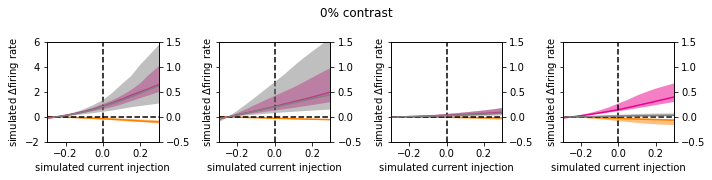

<Figure size 720x180 with 0 Axes>

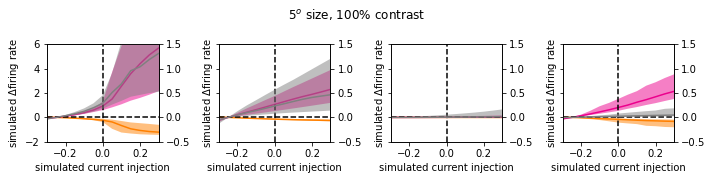

<Figure size 720x180 with 0 Axes>

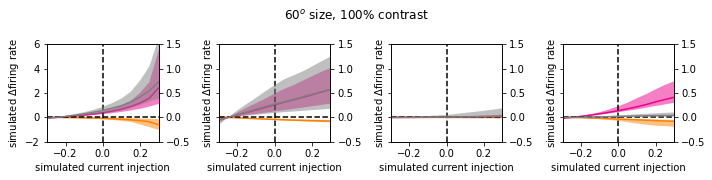

<Figure size 720x180 with 0 Axes>

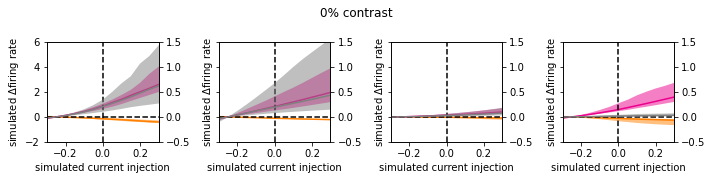

<Figure size 720x180 with 0 Axes>

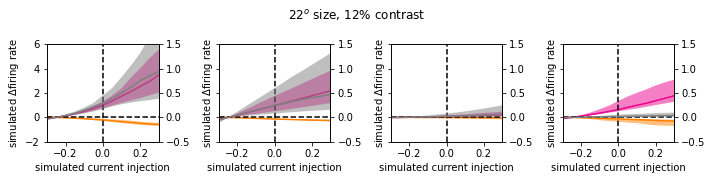

<Figure size 720x180 with 0 Axes>

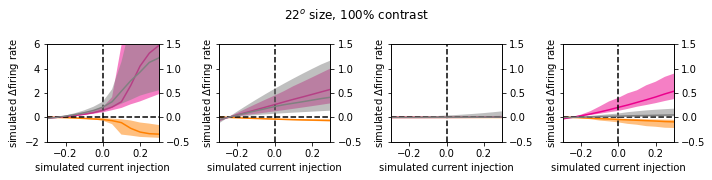

In [147]:
%load_ext autoreload
%autoreload 2

alpha = 0.5
izero = 15
zero_subtracted = True

norm_to_mean = True

lkat = ut.k_and(*[network_resps[iconn].max(1).max(1).max(1) < 10 for iconn in [0,2,3,4]])

reload(ut)

def plot_nonlinearity(ax, network_resp,color,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = network_resp - network_resp[:,izero:izero+1]
    else:
        to_plot = network_resp - 0
    ax.plot(opto_levels,np.nanmedian(to_plot,0),c=color,label=label)
    ax.fill_between(opto_levels,np.nanpercentile(to_plot,pct_l,axis=0),np.nanpercentile(to_plot,pct_u,axis=0),facecolor=color,alpha=alpha)

def plot_cell_intrinsic_resp(cell_intrinsic_resp,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = cell_intrinsic_resp - cell_intrinsic_resp[:,izero:izero+1]
    else:
        to_plot = cell_intrinsic_resp - 0
    plt.plot(opto_levels,np.nanmean(to_plot,0),c='k',linestyle='dashed',label=label)
    
np.random.seed(0)
this_lkat = np.random.randint(lkat.sum())
this_lkat = slice(this_lkat, this_lkat+1)

xlim = 0.3#0.5
    
# itype = 2
pct_l,pct_u = 16,84
cs = [None,np.array((1,0.65,0)),np.array((1,0,1)),None]
for istim,title in zip([0,5,35,18,20,23],['0% contrast','5$^o$ size, 100% contrast','60$^o$ size, 100% contrast','0% contrast','22$^o$ size, 12% contrast','22$^o$ size, 100% contrast']):
    plt.figure(figsize=(10,2.5))
    fig, axs = plt.subplots(1, 4, figsize=(10,2.5), sharey=True)
 
    nrs = [network_resp,network_resp_no_sstvip,network_resp_no_pcvip,network_resp_no_pcpv]
    nr_baseline = network_resp
#     cs = ['k',np.array((1,0.65,0)),np.array((1,0,1)),np.array((0,0,1))]
    cs = [np.array((0.5,0.5,0.5)),np.array((1,0.5,0)),np.array((236, 0, 140))/255,np.array((0,0,1))]
    lbls = ['baseline','PC$\rightarrow$SST weights deleted','PC$\rightarrow$VIP weights deleted','PC$\leftrightarrow$PV weights deleted']


    for iplot,(nr,c,lbl) in enumerate(zip(nrs,cs,lbls)):
        if norm_to_mean:
            nr = ut.norm_middle_axes_to_mean(nr[:,:,:,:],nr_baseline[:,15,:,:])
        pc_ax = axs[iplot].twinx()
        for itype in range(3):
            if itype == 0:
                this_ax = pc_ax
            else:
                this_ax = axs[iplot]
            plot_nonlinearity(this_ax, nr[lkat][:,:,istim,itype],cs[itype],lbl)
        axs[iplot].axvline(0,c='k',linestyle='dashed')
        axs[iplot].axhline(0,c='k',linestyle='dashed')
        axs[iplot].set_xlim((-xlim,xlim))

        if norm_to_mean:
            axs[iplot].set_ylim((-2,6))
            pc_ax.set_ylim((-0.5, 1.5))
        else:
            axs[iplot].set_ylim((-1,3))
            pc_ax.set_ylim((-1, 3))
            
        axs[iplot].set_xlabel('simulated current injection')
        if zero_subtracted:
            axs[iplot].set_ylabel(r'simulated $\Delta$firing rate')
        else:
            axs[iplot].set_ylabel('simulated firing rate')
    fig.tight_layout()
    fig.suptitle(title)
    fig.tight_layout()
    save = False
    if save:
        plt.savefig('figures/network_nonlinearity_w_and_wo_ws_twinx_stim_%d.jpg'%istim,dpi=300)

# Get params

In [24]:
# nr = network_resp
nr = np.nanmean(YY_opto,3)# time average

import naka_rushton_analysis as nra
reload(nra)
x = opto_levels#-opto_levels.min()#+1
params = np.zeros((nr.shape[0],nr.shape[2],3,6))
use_zero_dims = True
for istim in range(nr.shape[2]):
    print(istim)
    for itype in range(3):
        if use_zero_dims:
            if itype in {0, 1}:
                zero_dims = [False, True, False, True, False, False]
            else:
                assert itype == 2
                zero_dims = [False, True, False, False, False, False]
        else:
            zero_dims = None
        params[:,istim,itype,:],_ = nra.fit_opt_params_two_asymptote_fn(x, nr[:,:,istim,itype])#, zero_dims=zero_dims)
        # params[:,istim,itype,:],_ = nra.fit_opt_params_two_asymptote_fn_joint(x, nr[:,:,istim,itype], zero_dims=zero_dims)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [129]:
params.shape
params[:,istim,itype,:]

(94, 36, 3, 6)

In [113]:
midpoints = params[:, :, itype, 0].reshape((-1, 6, 6))
# np.save(os.path.expanduser('~/Documents/notebooks/mossing-PC/shared_data/vip_sigmoid_midpoints.npy'), midpoints)

scales = params[:, :, itype, 5].reshape((-1, 6, 6))
# np.save(os.path.expanduser('~/Documents/notebooks/mossing-PC/shared_data/vip_sigmoid_scales.npy'), scales)


'/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/figures_notebooks_agos'

# Plot only Pyr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


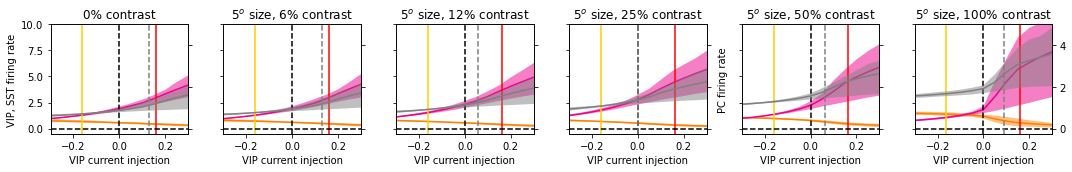

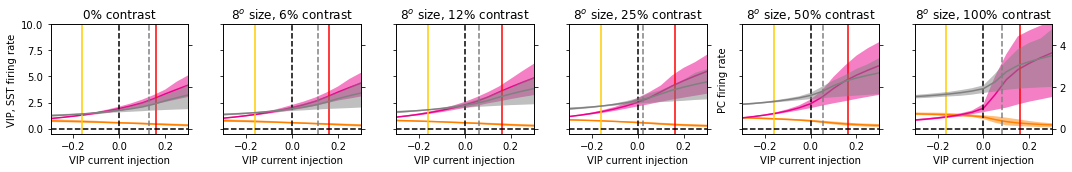

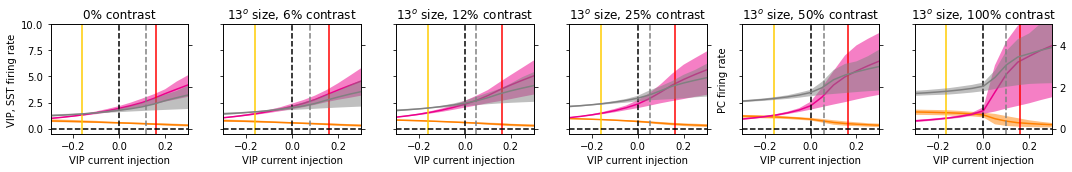

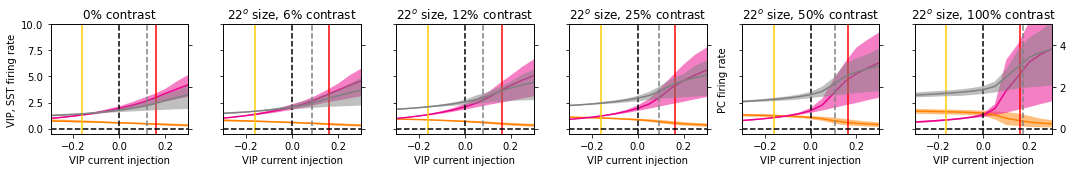

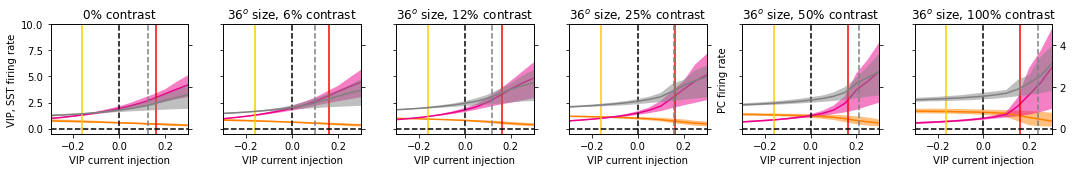

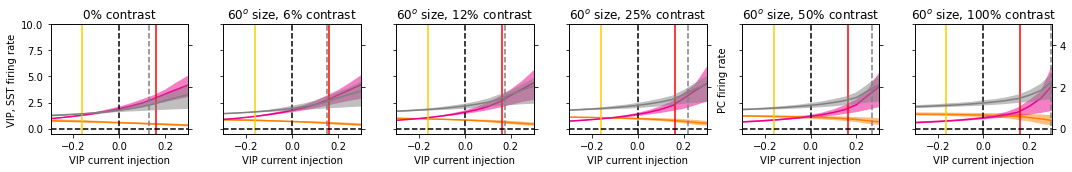

In [152]:
%load_ext autoreload
%autoreload 2

alpha = 0.5

izero = 15
zero_subtracted = False

norm_to_mean = True

lkat = ut.k_and(*[network_resps[iconn].max(1).max(1).max(1) < 10 for iconn in [0,2,3,4]])

reload(ut)

def plot_nonlinearity(ax, network_resp,color,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = network_resp - network_resp[:,izero:izero+1]
    else:
        to_plot = network_resp - 0
    ax.plot(opto_levels,np.nanmean(to_plot,0),c=color,label=label)
    ax.fill_between(opto_levels,np.nanpercentile(to_plot,pct_l,axis=0),np.nanpercentile(to_plot,pct_u,axis=0),facecolor=color,alpha=alpha)

def plot_cell_intrinsic_resp(cell_intrinsic_resp,label,zero_subtracted=zero_subtracted):
    if zero_subtracted:
        to_plot = cell_intrinsic_resp - cell_intrinsic_resp[:,izero:izero+1]
    else:
        to_plot = cell_intrinsic_resp - 0
    plt.plot(opto_levels,np.nanmean(to_plot,0),c='k',linestyle='dashed',label=label)
    
    
usize = np.array((5,8,13,22,36,60))
# itype = 2
pct_l,pct_u = 16,84
# istims = [0,5,35,18,20,23]
all_titles = [f"{size}$^o$ size, {contrast}% contrast" for size in usize for contrast in ucontrast]
all_titles[0::6] = ["0% contrast" for _ in range(6)]
# titles = ['0% contrast','5$^o$ size, 100% contrast','60$^o$ size, 100% contrast','0% contrast','22$^o$ size, 12% contrast','22$^o$ size, 100% contrast']
cs = [None,np.array((1,0.65,0)),np.array((1,0,1)),None]

this_target_amplitude = np.nanmean(params[:,5::6,0,0],axis=1)
line_loc = this_target_amplitude.mean()

xlim = 0.3 # 0.5

midline=np.mean(params[:,:,0,0],0)

istims_list = [np.arange(k,k+6,1) for k in range(0,36,6)]

for istim_choice in range(len(istims_list)):
    istims = istims_list[istim_choice]
    titles = [all_titles[istim] for istim in istims]
    for istyle in range(1):
        fig, axs = plt.subplots(1,len(istims),figsize=(2.5*len(istims),2.5), sharey=True)
        this_lkat = slice(None)
        for iistim,(istim,title) in enumerate(zip(istims,titles)):

            nrs = [network_resp,network_resp_no_sstvip,network_resp_no_pcvip,network_resp_no_pcpv]
            nr_baseline = network_resp
            cs = [np.array((0.5,0.5,0.5)),np.array((1,0.5,0)),np.array((236, 0, 140))/255,np.array((0,0,1))]
            lbls = ['baseline','PC$\rightarrow$SST weights deleted','PC$\rightarrow$VIP weights deleted','PC$\leftrightarrow$PV weights deleted']
            for iplot,(nr,c,lbl) in enumerate(zip(nrs[:1],cs[:1],lbls[:1])):

                if norm_to_mean:
                    nr = ut.norm_middle_axes_to_mean(nr[:,:,:,:],nr_baseline[:,15,:,:])
                pc_ax = axs[iistim].twinx()
                for itype in range(3):
                    if itype==0:
                        this_ax = pc_ax
                    else:
                        this_ax = axs[iistim]
                    plot_nonlinearity(this_ax, nr[lkat][this_lkat][:,:,istim,itype],cs[itype],lbl)
                axs[iistim].axvline(line_loc,c=np.array((1,0,0)))
                axs[iistim].axvline(-line_loc,c=np.array((1,0.8,0)))
                axs[iistim].axvline(0,c='k',linestyle='dashed')
                axs[iistim].axhline(0,c='k',linestyle='dashed')
                axs[iistim].axvline(midline[istim],c='gray',linestyle='dashed')
                
                if istyle == 2:
                    axs[iistim].set_xlim((-0.5, 0.5))
                else:
                    axs[iistim].set_xlim((-xlim, xlim))

                if norm_to_mean:
                    axs[iistim].set_ylim((-0.5,10))
                    pc_ax.set_ylim((-0.25, 5.0))
                else:
                    axs[iistim].set_ylim((-1,3))
                    pc_ax.set_ylim((-1, 3))

                if iistim < len(istims)-1:
                    pc_ax.set_yticklabels([])

                axs[iistim].set_xlabel('VIP current injection')
                if zero_subtracted:
                    axs[iistim].set_ylabel(r'$\Delta$firing rate')
                else:
                    if iistim == 0:
                        axs[iistim].set_ylabel('VIP, SST firing rate')
                    if iistim == 3:
                        pc_ax.set_ylabel('PC firing rate')
            fig.tight_layout()
            axs[iistim].set_title(title)
            fig.tight_layout()
            save = False

        plt.savefig(figures_path+'/network_nonlinearity_all_connections_size_contrast_samples.pdf',dpi=300)

In [144]:
midline

array([1.27545322e-01, 1.30175993e-01, 5.71905294e-02, 2.46761799e-04,
       6.17799761e-02, 8.91292208e-02, 1.29140355e-01, 1.11698206e-01,
       6.25056287e-02, 2.45812790e-02, 5.28353620e-02, 8.15946451e-02,
       1.16514537e-01, 7.90806985e-02, 4.72093343e-02, 5.49302675e-02,
       6.01970140e-02, 9.62127014e-02, 1.22267494e-01, 8.74433593e-02,
       7.89500525e-02, 9.12338148e-02, 1.05996632e-01, 1.70632992e-01,
       1.25367457e-01, 1.01780984e-01, 1.17990319e-01, 1.59742511e-01,
       2.11446721e-01, 2.37092579e-01, 1.28019139e-01, 1.53629084e-01,
       1.74200654e-01, 2.19163167e-01, 2.65594139e-01, 2.94190600e-01])

In [151]:
istims_list

[array([ 6,  7,  8,  9, 10, 11]),
 array([12, 13, 14, 15, 16, 17]),
 array([18, 19, 20, 21, 22, 23]),
 array([24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35])]

In [130]:
ucontrast

array([  0,   6,  12,  25,  50, 100])

In [98]:
nr[lkat][this_lkat][:,:,istim,itype].shape

(80, 41)

In [26]:
itype = 0


def compute_amplitude_at_x0(set_of_params):
    x0, a1, b1, a2, b2, lam = set_of_params
    return a2*x0 + b2 - (a1*x0 + b1)

def apply_func_to_pc_params(params, func):
    itype = 0
    output = np.zeros(params.shape[:2])
    for iwt in range(params.shape[0]):
        for istim in range(params.shape[1]):
            output[iwt,istim] = func(params[iwt,istim,itype,:])
    return output

amplitude_at_x0 = apply_func_to_pc_params(params, compute_amplitude_at_x0)
# np.save(os.path.expanduser("~/Documents/notebooks/mossing-PC/shared_data/vip_sigmoid_amplitude_at_x0.npy"), amplitude_at_x0)

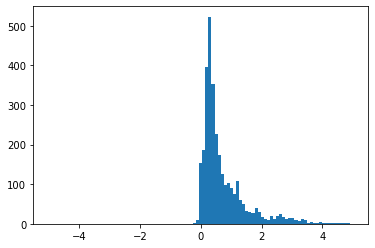

In [36]:
amplitude_at_x0
plt.hist(amplitude_at_x0.flatten(),bins=np.linspace(-5,5,100));

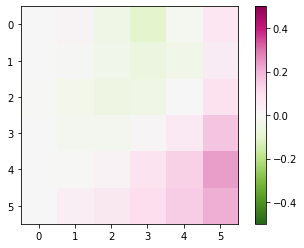

In [173]:
midpoints # model nr, size, contrast
plt.imshow(midpoints[1,:,:],cmap='PiYG_r',vmin=-0.5,vmax=0.5);
plt.colorbar()

In [174]:
midpoints.shape

(94, 6, 6)

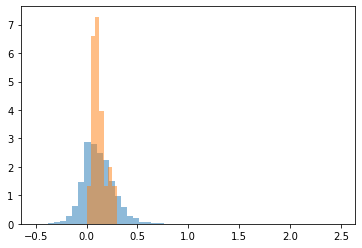

In [176]:
plt.hist(params[:,:,0,0].flatten(),50,density=True,alpha=0.5);
plt.hist(np.nanmean(params[:,:,0,0],0).flatten(),7,density=True,alpha=0.5);


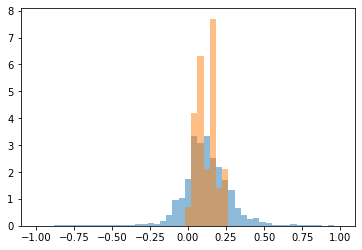

In [183]:
plt.hist(params[:,:,1,0].flatten(),np.linspace(-1,1,50),density=True,alpha=0.5);
plt.hist(np.nanmean(params[:,:,1,0],0).flatten(),np.linspace(-1,1,50),density=True,alpha=0.5);


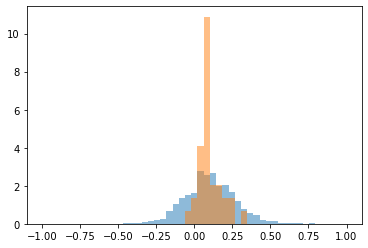

In [184]:
plt.hist(params[:,:,2,0].flatten(),np.linspace(-1,1,50),density=True,alpha=0.5);
plt.hist(np.nanmean(params[:,:,2,0],0).flatten(),np.linspace(-1,1,50),density=True,alpha=0.5);
